# Updated Project Proposal
**Artificial Intelligence COMPSCI 383 Group Project**

Group name: Team XYZ <br>
Code Repository: https://github.com/COMPSCI-383-Spring2025/group-project-team-xyz <br>
Group members: Quoc Thien Vi Lam, Gabriella Wang, Stanley Yang <br><br>

Project Idea Proposal: Playing Wordle<br>

Description:<br>
The goal of this project is to prompt a large language model (LLM) to play the game of Wordle using words from a predefined dataset. The LLM will iteratively guess words, receiving feedback in the form of correct letter placements (maybe an ‘O’), correct letters in the wrong place (‘_’), and incorrect letters (‘X’). Based on this feedback, the model will refine its guesses until it finds the correct word or use up its six attempts.

Some metrics we can use to evaluate the LLM’s performance are:

- The number of tries it takes to guess the correct word.
- Whether it successfully guessed the word within the 6 guess limit
  - A binary value for one trial: 0 for failure and 1 for success
- The percentage of words guessed correctly within the 6 guess limit for entire sample
<br><br>

This project will help assess the reasoning and adaptability of LLMs in structured word-guessing tasks and could provide insights into optimizing their problem-solving strategies.

Dataset for project:
https://www.kaggle.com/datasets/cprosser3/wordle-5-letter-words <br>
Has 5 columns where each column contain a letter of the 5-letter word.


# Data Cleaning and Preprocessing

In [3]:
#imports section
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [4]:
# Load our dataset
df = pd.read_csv("5_letters.csv")
print(f"(rows, columns) = {df.shape}")

(rows, columns) = (2499, 5)


In [5]:
# Check if there's any duplicate rows, if there is, we drop them
num_duplicates = df.duplicated().sum()
print(f"number of duplicate rows: {num_duplicates}")

number of duplicate rows: 0


In [6]:
# Check if there's any rows with missing letters, if there is, we need to drop them
num_missing = df.isnull().any(axis = 1).sum()
print(f"number of rows with missing letters: {num_missing}")

number of rows with missing letters: 0


In [7]:
num_rows = df.shape[0]
# num_remove represents the number of rows to remove so our dataset has 1000 rows left
num_remove = num_rows - 1000

# Obtain num_remove number of random row indices to remove
indexes_to_drop = df.sample(n = num_remove, random_state = 42).index

df.drop(indexes_to_drop, inplace = True)

df.reset_index(drop = True, inplace = True)
print(f"(rows, columns) = {df.shape}")

(rows, columns) = (1000, 5)


**Prompting template:**

We are playing Wordle, try to guess the word within 6 attempts. This is your xxx attempt.

These are incorrect letters that have been guessed: {}

Notes:
'O' represents a correct letter in the correct position.
‘_’ represents a correct letter in the wrong position.
‘X’ represents an incorrect letter.

**Example:**

We will be looping through all the words in our dataset, and for the first out of six attempts on the first word, we will use the prompt:

We are playing Wordle, try to guess the word within 6 attempts. This is your first attempt.

These are incorrect letters that have been guessed: {}

Notes:
'O' represents a correct letter in the correct position.
‘_’ represents a correct letter in the wrong position.
‘X’ represents an incorrect letter.


Let's say our first word is 'aback' and the LLM returns the guess 'apple'. Then, we will be returning 'O X X X X'. As for the next iteration, our set our incorrect letters that have been guessed would be {'p', 'l', 'e'}.

**Parsing**

We will be using an object or data structure to parse the LLM's responses. It will store:
- The number of iterations it takes for the LLM to correctly guess the word, with the limit being 6. 
- A boolean value which is True (1) if the LLM guessed the word, and False (0) otherwise.
- At most 6 word guesses of similar form as 'O X X X _'. However, we will be encoding these to numerical values, so X → 0, _ → 1, O → 2. Therefore if the first word guess made us return 'O X X X _'. Then, we will be setting firstWordGuess = [2, 0, 0, 0, 1]. If the LLM took five guesses to guess the word, then sixthWordGuess = NULL.

# Exploratory Data Analysis

In [8]:
# Check the percentage of letters that are vowels
vowels = {'a', 'e', 'i', 'o', 'u'}
total_vowels = 0
for col in df.columns:
    total_vowels += df[col].map(lambda x: x in vowels).sum()
print(f"percentage of letters that are vowels: {(total_vowels/5000)*100:.2f}%")

percentage of letters that are vowels: 35.40%


We can see that out of 1000 letters, vowels makes up 35.4% of the letters. This suggests that most words have vowels as their letters and so when playing Wordle, the initial word guess should have at least 1 vowel since the probability of a word containing at least one vowel is very high.

If we use $P(letter = vowel) = 0.354$, then the probability of a word containing no vowels, assuming the probability of a letter appearing is independent of the letter that comes before it, is $(1-P(letter = vowel))^5 = (1-0.354)^5 = 0.11$. 

In [9]:
bool_df = pd.DataFrame()

for col in df.columns:
    bool_df[col] = df[col].map(lambda x: x in vowels)

# Obtain the number of rows that has at least one vowel 
num_rows_with_vowel = bool_df.any(axis = 1).sum()

print(f"number of rows containing at least one vowel: {num_rows_with_vowel}")

number of rows containing at least one vowel: 998


We can observe that in our dataset, only 2 words contains no vowels, which supports the argument that the initial word guess should have at least 1 vowel.

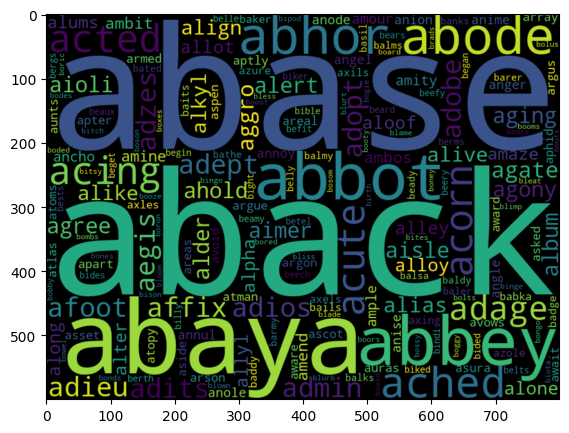

In [10]:
complete_words = df.apply(lambda row: ''.join(row),axis=1)
combined_all_words = ' '.join(complete_words)

generate_word_cloud = WordCloud(width=800, height=600, background_color='black').generate(combined_all_words)

plt.figure(figsize=(10, 5))
plt.imshow(generate_word_cloud, interpolation='bilinear')
plt.show()

# The word cloud represents the frequency of words through their size.
#  For example, words like 'abase', 'aback', and 'abaya' appear larger than the others because they top the dataset.
#  Furthermore, the dataset organizes words in alphabetical order and indicates the percentage likelihood of each word's appearance in the passage.

The word cloud clearly indicates words like 'abase', 'aback', and 'abaya' has a higher frequency than other words, but since we have verified that there's no duplicate words in our dataset in the Data Cleaning and Preprocessing section, we know the frequency of all the words in our dataset is 1. Therefore, a wordcloud is not particularly helpful and it can be misleading as it's conveying there's a higher frequency of the word 'abase', compared to the frequency of the word 'acorn'.

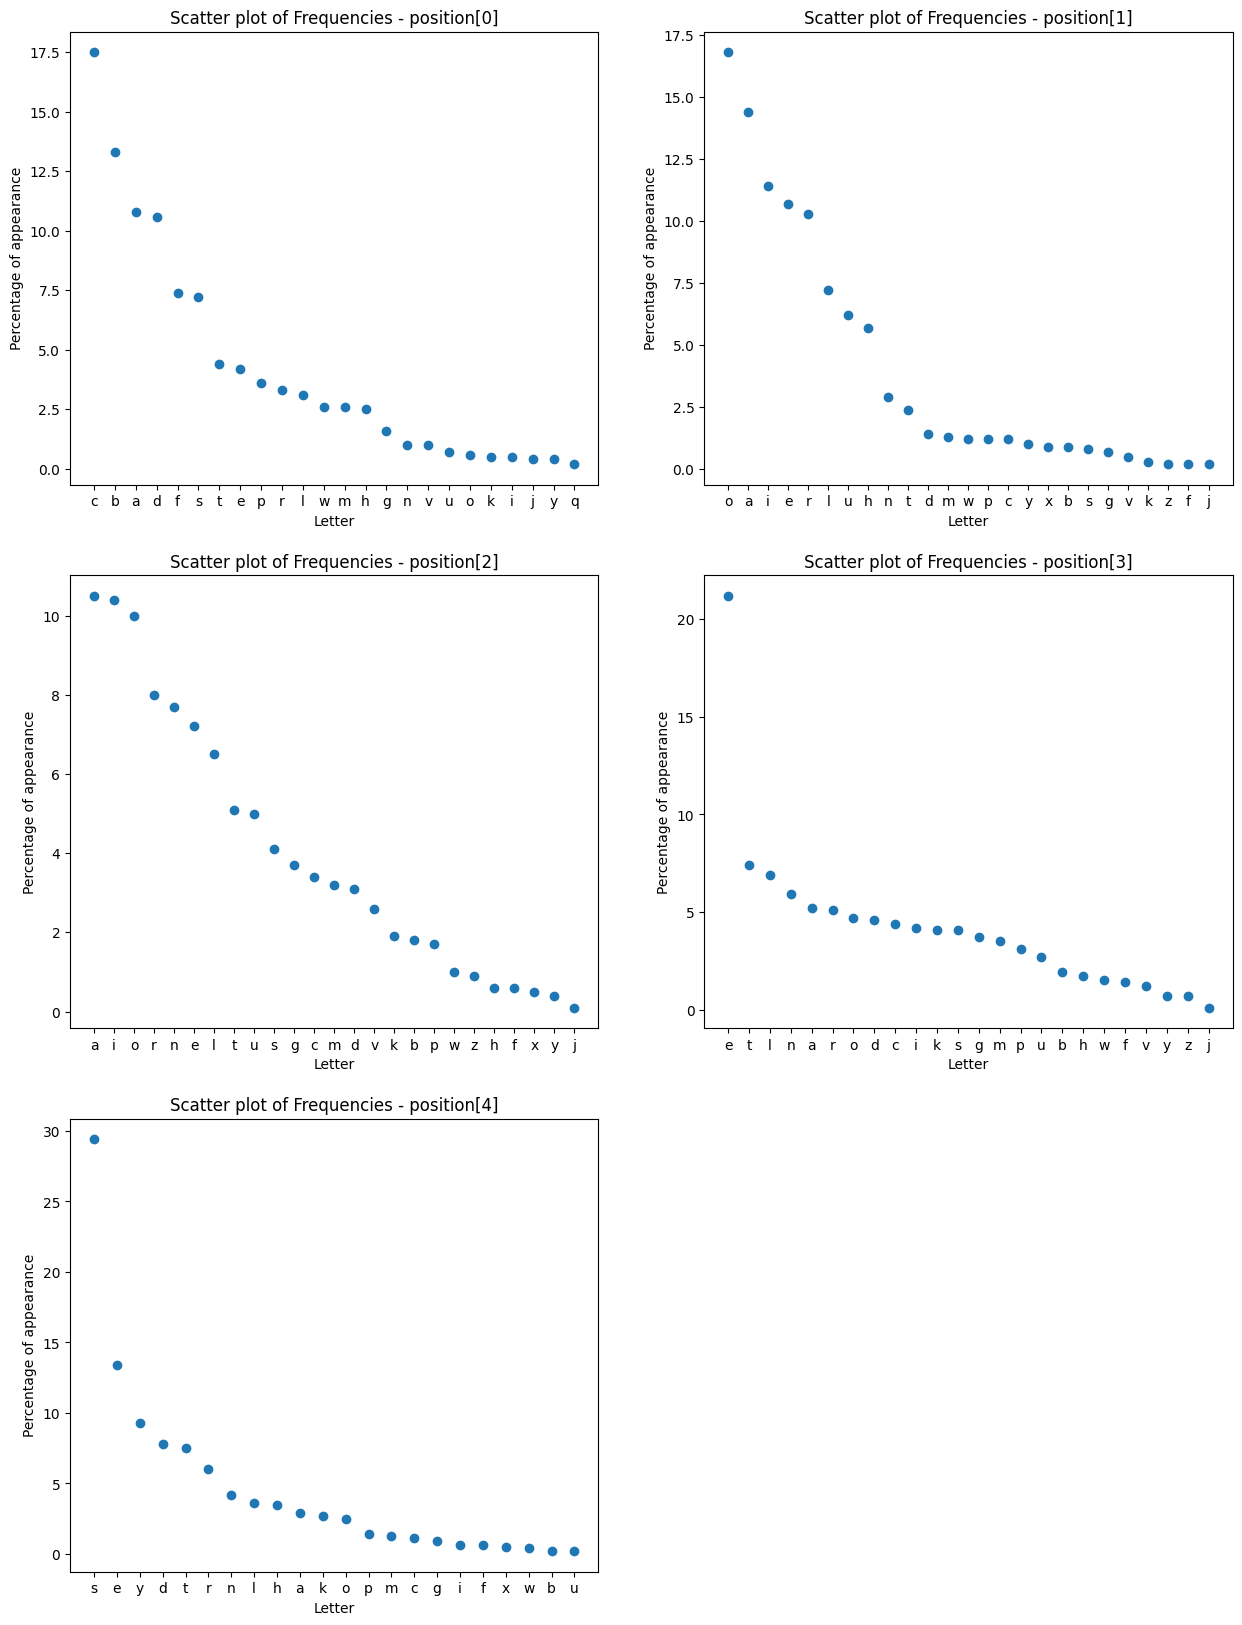

In [11]:
#scatterplot each letter at each position
five_columns = []
data_set_letter_and_frequence_each_column = []
for i in range(0,5):
    five_columns.append(df.iloc[:,i])

for i in range(5):
    frquencies = five_columns[i].value_counts()    
    data_set_letter_and_frequence_each_column.append(frquencies.reset_index())
    data_set_letter_and_frequence_each_column[i].columns = ['Letter', 'Frequency']
    data_set_letter_and_frequence_each_column[i]['Frequency'] = (data_set_letter_and_frequence_each_column[i]['Frequency'] / 
                                                                 data_set_letter_and_frequence_each_column[i]['Frequency'].sum())*100
plt.figure(figsize=(15, 20))
for i in range(5):
    plt.subplot(3, 2, i + 1)
    plt.scatter(data_set_letter_and_frequence_each_column[i]['Letter'], data_set_letter_and_frequence_each_column[i]['Frequency'] )
    plt.title(f'Scatter plot of Frequencies - position{[i]}')
    plt.xlabel('Letter')
    plt.ylabel('Percentage of appearance')

#The scatter plot shows the percentage likelihood of a letter being present at a specific position.
#  For example, at position 0, the letter 'c' has the highest probability of appearing in a word.

We can see that consonants has a very high likelihood of being the first letter of the word, such as letters 'c', 'b', 'd', 'f', 's'. Vowels rarely occur in the first letter with the exception of 'a'. However, we observe that there's a very high chance that vowels make up the second letter of a word. The letter 'r' is the most common consonant here, suggesting some common patterns like 'br', 'cr', 'dr', 'fr. As for the third letter, we observe a high percentage of vowels appearing here. The fourth letter has a mix of vowels and consonants, but the percentage of the letter 'e' appearing gaps the other letters' percentages of appearing. Lastly, for the fifth letter, we can see another gap between the most common letter and the second most common letter - 's' has around a 30% chance of appearing as the last letter of a word. Since 'e' has about a 20% chance of appearing as the fourth letter, this means around 6% of the words ends with 'es'.

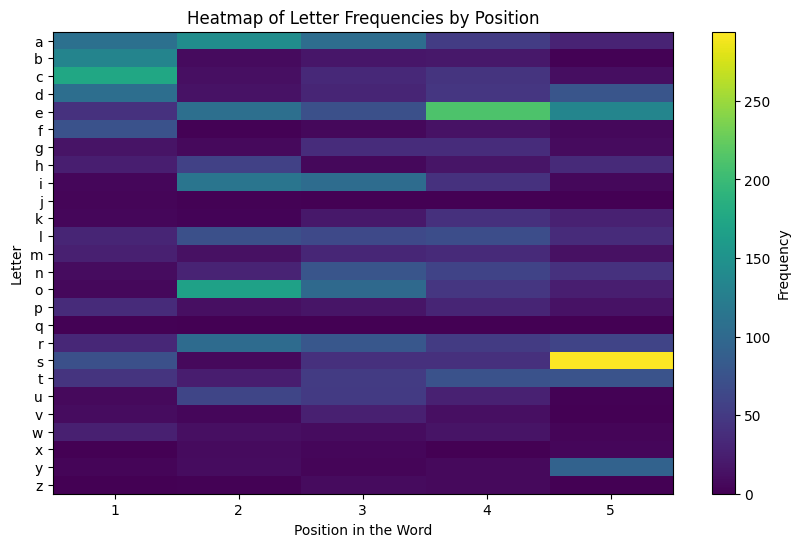

In [12]:
#Heatmap of letter frequency in each position
letters = [chr(i) for i in range(97, 123)] #alphabet
position_freq = {}

for col in df.columns:
    freq = df[col].value_counts().reindex(letters, fill_value=0)
    position_freq[col] = freq

freq_df = pd.DataFrame(position_freq)

plt.figure(figsize=(10, 6))
plt.imshow(freq_df, aspect='auto', cmap='viridis')
plt.colorbar(label='Frequency')
plt.xticks(ticks=np.arange(len(freq_df.columns)), labels=freq_df.columns)
plt.yticks(ticks=np.arange(len(freq_df.index)), labels=freq_df.index)
plt.xlabel('Position in the Word')
plt.ylabel('Letter')
plt.title('Heatmap of Letter Frequencies by Position')
plt.show()

This can be further highlighted using a heatmap, we can see that 'e' has a very high frequency of occurring in the fourth letter of the word and 's' has a very high frequency of occurring in the fifth letter of the word.

In [13]:
print("Head of the DataFrame:")
print(df.head())

print("\nDataFrame Info:")
print(df.info())

print("\nDataFrame Shape:", df.shape)

vowel_freq = {}
for col in df.columns:
    col_letters = df[col].str.lower()
    vowel_freq[col] = col_letters.apply(lambda x: x in vowels).value_counts().reindex([True, False], fill_value=0)

vowel_freq_df = pd.DataFrame(vowel_freq)
print("Vowel Frequency by Position:")
print(vowel_freq_df)

Head of the DataFrame:
   1  2  3  4  5
0  a  b  a  c  k
1  a  b  a  s  e
2  a  b  a  y  a
3  a  b  b  e  y
4  a  b  b  o  t

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   1       1000 non-null   object
 1   2       1000 non-null   object
 2   3       1000 non-null   object
 3   4       1000 non-null   object
 4   5       1000 non-null   object
dtypes: object(5)
memory usage: 39.2+ KB
None

DataFrame Shape: (1000, 5)
Vowel Frequency by Position:
         1    2    3    4    5
True   168  595  431  380  196
False  832  405  569  620  804


This gives us a better idea of the vowel composition in our words. We can see that there's about a 60% chance the second letter and 43% chance the third letter of the word is a vowel. Although there's a 38% chance the fourth letter is also a vowel, from our scatter plots before, we know that the vowel 'e' alone has about a 20% chance of appearing.

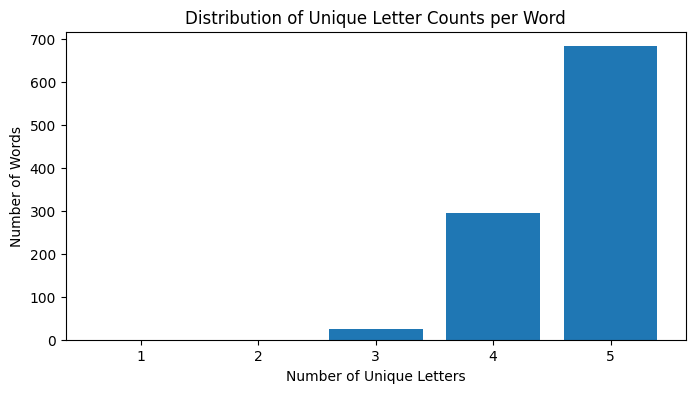

In [14]:
# Visualize the distinct letters in each word
words = df.apply(lambda row: ''.join(str(letter) for letter in row), axis=1)
unique_letter_counts = words.apply(lambda word: len(set(word.lower())))

unique_dist = unique_letter_counts.value_counts().reindex(range(1, 6), fill_value=0).sort_index()
plt.figure(figsize=(8, 4))
plt.bar([str(x) for x in unique_dist.index], unique_dist.values)
plt.xlabel("Number of Unique Letters")
plt.ylabel("Number of Words")
plt.title("Distribution of Unique Letter Counts per Word")
plt.show()

This bar chart shows up that around 680 words in our dataset are made up of 5 unique letters. Only about 300 words are made up of 4 unique letters and about 20 words are made up fo 3 unique letters. As for words with only 2 or 1 unique letters, none of them exists in our dataset.

In [15]:
#Pairs of letters in a word
def extract_pairs(word):
    return [word[i:i+2] for i in range(len(word) - 1)]

all_pairs = words.apply(extract_pairs).sum()
pairs_counts = Counter(all_pairs)

common_pairs = pairs_counts.most_common(10)
print("10 Most Common Pairs:")
print(common_pairs)

10 Most Common Pairs:
[('es', 78), ('er', 62), ('ed', 61), ('in', 56), ('ch', 53), ('al', 53), ('de', 50), ('re', 48), ('ca', 47), ('co', 46)]


We can see that 'es' is indeed a very common pair of letters in a word. As we stated before, since about 6% of words have 'es' as the ending letters, then that means about 2% of words have the pair 'es' in other parts of the word. Something to take note of is how 9 out of 10 most common pairs has 1 vowel. This further emphasizes the importance of vowels and how it would be ideal to include vowels in Wordle guesses.

In [16]:
#Symmetry in words
palindromes = words[words.apply(lambda word: word.lower() == word.lower()[::-1])]
print("Palindromes in the Dataset:")
print(palindromes.tolist())
print("Count: ", palindromes.count())

# Count words where the first and last letter match 
first_last_match = words[words.apply(lambda word: word[0].lower() == word[-1].lower())]
grouped_words = {}
for word in first_last_match:
    key = word[0]
    if key not in grouped_words:
        grouped_words[key] = []
    grouped_words[key].append(word)

print("Words with the first and last letter matching:")
for letter, word in grouped_words.items():
    print(f"{letter.upper()}: {' '.join(word)}")
print("Count: ", first_last_match.count())

Palindromes in the Dataset:
['civic']
Count:  1
Words with the first and last letter matching:
A: abaya alpha asura
B: blurb
C: civic colic comic conic
D: diced dived doled domed doped dried dryad
E: elide elope elute ensue erode exile exude
G: going
H: harsh
K: knock
L: legal
M: modem
R: river
S: sales seals seams seats shops shots shows skies skins slots soils sorts souls spots spurs stays stems steps sucks swiss
T: trust tweet twist
Count:  51


Palindromes are actually very rare in our dataset as only 1 palindrome exists. This palindrome actually makes up one of the few words that only has 3 unique letters. As for words with the same first and last letter, there are 51 words, with 's' being the same first and last letter making up 20 words.

In [17]:
import pickle

#save the variable to a file
with open('words.pkl', 'wb') as f:
    pickle.dump(words, f)

%store words

Stored 'words' (Series)


/Users/stanleyyang/Library/Python/3.10/lib/python/site-packages/IPython/extensions/storemagic.py:229: UserWarning: This is now an optional IPython functionality, setting autorestore/words requires you to install the `pickleshare` library.
  db[ 'autorestore/' + arg ] = obj
